In [1]:
using Dates
using ITensors
using LaTeXStrings
using StatsBase
using Statistics
using Plots
using ProgressMeter
using JLD

global const nsweeps::Int = 100
global const maxdim::Int = 10000
global const cutoff::Float64 = 1e-12
global const noise::Vector{Float64} = [1e-5, 1e-6, 0.0]

global const observer::DMRGObserver{Float64} = DMRGObserver(energy_tol=1e-6)

global const rho::Float64 = (sqrt(5) - 1) / 2  # 1 / phi
global const rho2::Float64 = (3 - sqrt(5)) / 2;  # 1 / phi^2

In [2]:
function build_HAos(n::Int, edges::Vector{}, s::Int, t::Int, A=50)
    N = size(edges)[1]

    os = OpSum()

    J = zeros(N, N)
    K = zeros(N)

    for i in 1:n
        si = findfirst(edges .== ((s, i),))
        is = findfirst(edges .== ((i, s),))

        ti = findfirst(edges .== ((t, i),))
        it = findfirst(edges .== ((i, t),))

        for j in 1:n
            sj = findfirst(edges .== ((s, j),))
            js = findfirst(edges .== ((j, s),))

            # build Hs
            if (sj != nothing) && (si != nothing) && (sj != si)
                os .+= 1, "Z", sj, "Z", si
                J[sj, si] += 1
            end

            if (js != nothing) && (is != nothing) && (js != is)
                os .+= 1, "Z", js, "Z", is
                J[js, is] += 1
            end

            if (js != nothing) && (si != nothing) && (js != si)
                os .+= -1, "Z", js, "Z", si
                J[js, si] += -1
            end

            if (sj != nothing) && (is != nothing) && (sj != is)
                os .+= -1, "Z", sj, "Z", is
                J[sj, is] += -1
            end

            tj = findfirst(edges .== ((t, j),))
            jt = findfirst(edges .== ((j, t),))

            # build Ht
            if (tj != nothing) && (ti != nothing) && (tj != ti)
                os .+= 1, "Z", tj, "Z", ti
                J[tj, ti] += +1
            end

            if (jt != nothing) && (it != nothing) && (jt != it)
                os .+= 1, "Z", jt, "Z", it
                J[jt, it] += +1
            end

            if (jt != nothing) && (ti != nothing) && (jt != ti)
                os .+= -1, "Z", jt, "Z", ti
                J[jt, ti] += -1
            end

            if (tj != nothing) && (it != nothing) && (tj != it)
                os .+= -1, "Z", tj, "Z", it
                J[tj, it] += -1
            end

            # build Hij
            if (i != s) && (i != t)
                if i == j
                    continue
                end

                ij = findfirst(edges .== ((i, j),))
                ji = findfirst(edges .== ((j, i),))
                for k in 1:n
                    if i == k
                        continue
                    end
                    ki = findfirst(edges .== ((k, i),))
                    ik = findfirst(edges .== ((i, k),))

                    if (ij != nothing) && (ik != nothing) && (ij != ik)
                        os .+= 1, "Z", ij, "Z", ik
                        J[ij, ik] += 1
                    end

                    if (ji != nothing) && (ki != nothing) && (ji != ki)
                        os .+= 1, "Z", ji, "Z", ki
                        J[ji, ki] += 1
                    end

                    if (ji != nothing) && (ik != nothing) && (ji != ik)
                        os .+= -1, "Z", ji, "Z", ik
                        J[ji, ik] += -1
                    end

                    if (ij != nothing) && (ki != nothing) && (ij != ki)
                        os .+= -1, "Z", ij, "Z", ki
                        J[ij, ki] += -1
                    end
                end
            end
        end

        # Hs
        if (si != nothing)
            os .+= -4, "Z", si
            K[si] += -4
        end
        if (is != nothing)
            os .+= +4, "Z", is
            K[is] += +4
        end
        # Ht
        if (ti != nothing)
            os .+= +4, "Z", ti
            K[ti] += +4
        end
        if (it != nothing)
            os .+= -4, "Z", it
            K[it] += -4
        end
    end

    J = J .+ transpose(J)

    os = OpSum()
    for i in 1:N
        for j in i+1:N
            if J[i, j] != 0
                os += J[i, j], "Z", i, "Z", j
            end
        end
    end

    for i in 1:N
        if K[i] != 0
            os += K[i], "Z", i
        end
    end

    os *= A / 4
    J *= A / 4
    K *= A / 4
    return os, J, K
end


function build_HBos(N::Int, W, B=1)
    os = OpSum()
    for j in 1:N
        os .+= B/2*W[j], "Z", j
    end

    return os
end


function build_Hxos(N::Int)
    os = OpSum()
    for j in 1:N
        os .+= -1, "X", j
    end

    return os
end;

In [3]:
function compute_delta(sites::Vector{Index{Int64}}, N::Int, s::Float64, HA::MPO, HB::MPO, Hx::MPO;
                       psi0_init=MPS()::MPS, psi1_init=MPS()::MPS)
    H = (1-s)*Hx + s*(HA + HB)

    if psi0_init.rlim == 0
        state = StatsBase.sample(["Up", "Dn"], N)
        psi0_init = MPS(sites, state)
    end

    E0, psi0 = dmrg([(1-s)*Hx,s*HA,s*HB], psi0_init; nsweeps=nsweeps, maxdim=maxdim, cutoff=cutoff, noise=noise,
                    eigsolve_krylovdim=5, outputlevel=0, observer=observer)

    if psi1_init.rlim == 0
        state = StatsBase.sample(["Up", "Dn"], N)
        psi1_init = MPS(sites, state)
    end

    E1, psi1 = dmrg(H, [psi0], psi1_init; nsweeps=nsweeps, maxdim=maxdim, cutoff=cutoff, noise=noise,
                    eigsolve_krylovdim=6, outputlevel=0, observer=observer, weight=2)

    if E1 > E0
        return E1-E0, psi0, psi1
    else
        return E0-E1, psi1, psi0
    end
end


function find_delta_min(sites::Vector{Index{Int64}}, N::Int, HA::MPO, HB::MPO, Hx::MPO, 
                        psi0_f::MPS, psi1_f::MPS; tol=1e-3::Float64)
    a = 2 / (N+2)
    b = min(1, 4 / sqrt(N))

    h = b - a
    c = a + rho2 * h
    d = a + rho * h

    # Required steps to achieve tolerance
    n = trunc(Int, ceil(log(tol / h) / log(rho)))

    yd, psi0d, psi1d = compute_delta(sites, N, d, HA, HB, Hx, psi0_init=psi0_f, psi1_init=psi1_f)
    yc, psi0c, psi1c = compute_delta(sites, N, c, HA, HB, Hx, psi0_init=psi0d, psi1_init=psi1d)

    for k in 1:n
        if yc < yd
            b = d
            d = c
            yd = yc
            h = rho * h
            c = a + rho2 * h

            yc, psi0c, psi1c = compute_delta(sites, N, c, HA, HB, Hx, psi0_init=psi0c, psi1_init=psi1c)
        else
            a = c
            c = d
            yc = yd
            h = rho * h
            d = a + rho * h

            yd, psi0c, psi1d = compute_delta(sites, N, d, HA, HB, Hx, psi0_init=psi0d, psi1_init=psi1d)
        end
    end

    if yc < yd
        sc = (a + d) / 2
        psi0 = copy(psi0d)
        psi1 = copy(psi1d)
    else
        sc = (b + c) / 2
        psi0 = copy(psi0c)       
        psi1 = copy(psi1c)
    end

    dmin, psi0, psi1 = compute_delta(sites, N, sc, HA, HB, Hx, psi0_init=psi0, psi1_init=psi1)

    return sc, dmin, psi0
end;

In [4]:
ITensors.Strided.disable_threads()
ITensors.Strided.disable_threaded_mul()

ITensors.enable_combine_contract()
ITensors.enable_contraction_sequence_optimization()

In [5]:
using PyCall

py"""
from itertools import islice

import networkx as nx
from networkx.generators.harary_graph import hkn_harary_graph

from networkx.classes.function import path_weight

def two_sp(n, s, t, edges, W):
    G = hkn_harary_graph(3, n)
    G = nx.DiGraph(G)

    for i, e in enumerate(edges):
        G[e[0]][e[1]]['weight'] = W[i]

    p0, p1 = list(islice(nx.shortest_simple_paths(G, s, t, weight="weight"), 2))
    
    return p0, p1
"""

In [6]:
n = 5

graph_file = "analysis/data/harary/adj/adj_n=$n.jld"

Ad = load(graph_file, "Ad")
source = load(graph_file, "source")
target = load(graph_file, "target")

edges = Tuple.(findall(Ad .!= 0))
N = size(edges)[1]
sites = siteinds("S=1/2", N)

A = N
B = 1

# order = [(3,6), (5,6), (6,7), (2,5), (4,3), (4,5), (4,7), (1,4), (2,3), (1,7), (1,2)]
# order = [(6,7), (2,6), (5,6), (1,5), (1,2), (1,8), (8,4), (8,7), (7,3), (3,4), (2,3), (4,5)]
# order = [(4,8), (7,8), (9,8), (7,3), (6,7), (5,6), (9,5), (4,5), (4,3), (1,5), (1,9), (2,3), (1,2), (2,6)]
# order = [(3,8), (8,9), (8,7), (3,2), (4,3), (4,9), (4,5), (5,10), (10,9), (2,7), (6,7), (1,6), (10,1), (5,6), (1,2)]
# ordered = []
# for e in order
#     push!(ordered, e)
#     push!(ordered, (e[2], e[1]))
# end

# index_map = []
# for i in 1:N
#     push!(index_map, findfirst(x -> isequal(x, ordered[i]), edges))
# end

# edges = edges[index_map]

W = zeros(N)
for i in 1:N
    if reverse(edges[i]) in edges[1:i-1]
        W[i] = W[findfirst(edges .== (reverse(edges[i]),))]
    else
        W[i] = rand()
    end
end

# W = W[index_map]

os_HA, J, K = build_HAos(n, edges, source, target, A)
os_Hx = build_Hxos(N)

HA = MPO(os_HA, sites)
Hx = MPO(os_Hx, sites)

os_HB = build_HBos(N, W, B)
HB = MPO(os_HB, sites)

py_edges = [(e[1]-1, e[2]-1) for e in edges]
p0, p1 = py"two_sp"(n, source-1, target-1, py_edges, W)

p0 .+= 1
p1 .+= 1

p0 = [(p0[i], p0[i+1]) for i in 1:(length(p0)-1)]
p1 = [(p1[i], p1[i+1]) for i in 1:(length(p1)-1)]

p0 = indexin(p0, edges)
p1 = indexin(p1, edges)

dh = sum(abs.([n in p0 ? 1 : 0 for n in 1:N] .- [n in p1 ? 1 : 0 for n in 1:N]))

psi0_f = MPS(sites, [n in p0 ? "Up" : "Dn" for n in 1:N])
psi1_f = MPS(sites, [n in p1 ? "Up" : "Dn" for n in 1:N])

Hp = HA + HB
df = inner(psi1_f', Hp, psi1_f) - inner(psi0_f', Hp, psi0_f)

0.17667244514262848

In [7]:
@time sc, dmin, psi_sc = find_delta_min(sites, N, HA, HB, Hx, psi0_f, psi1_f)
sc, dmin, inner(psi0_f, psi_sc)^2

338.794298 seconds (117.24 M allocations: 464.134 GiB, 2.53% gc time, 3.41% compilation time)


(0.3517656739336134, 0.017463947547319947, 0.48782162096800774)

In [8]:
M = 100
Delta = zeros(M)
overlap0 = zeros(M)
overlap1 = zeros(M)
dH = zeros(M)

S = LinRange(0., 1, M+1)
S = S .+ S[2]
S = S[1:end-1]

psi0 = deepcopy(psi0_f)
psi1 = deepcopy(psi1_f)

@showprogress for (i, s) in Iterators.reverse(enumerate(S))
    Delta[i], psi0, psi1 = compute_delta(sites, N, s, HA, HB, Hx, psi0_init=psi0, psi1_init=psi1)

    overlap0[i] = inner(psi0_f, psi0)^2
    overlap1[i] = inner(psi1_f, psi0)^2
    dH[i] = abs(inner(psi1', Hp-Hx, psi0))
end

S = [0; S]
Delta = [2; Delta]
dH = [dH[1]; dH];

Progress: 100%|█████████████████████████████████████████| Time: 0:04:15


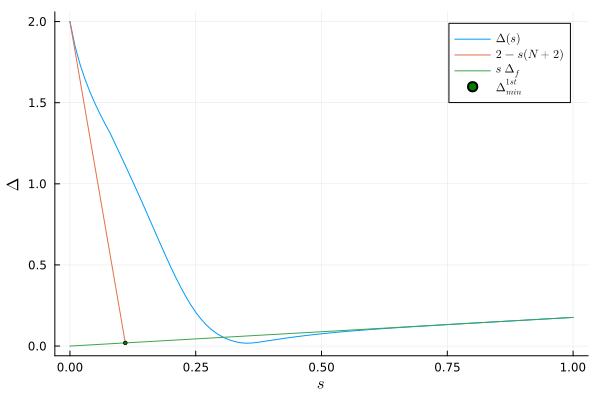

In [9]:
plot(S, [Delta],# overlap[:, 1] , overlap[:, 2]],
     label=[L"\Delta (s)" L"| \langle \psi_0 | \psi \rangle |^2" L"| \langle \psi_1 | \psi \rangle |^2"])

plot!(S[1:argmin(abs.(2 .- (N+2) * S))], 2 .- (N+2) * S[1:argmin(abs.(2 .- (N+2) * S))], label=L"2 - s (N+2)")
plot!(S, df*S, label=L"s\ \Delta_{f}")

sc_first = 2 / (2+N+df)
dmin_first = sc_first * df
# plot!([sc], [dmin], seriestype=:scatter, label=L"\Delta_{min}", markersize=2, color=:red)
plot!([sc_first], [dmin_first], seriestype=:scatter, label=L"\Delta_{min}^{1st}", markersize=2, color=:green)
plot!(xlabel=L"s", ylabel=L"\Delta")
# savefig("ex_delta_har.pdf")

In [10]:
using LsqFit

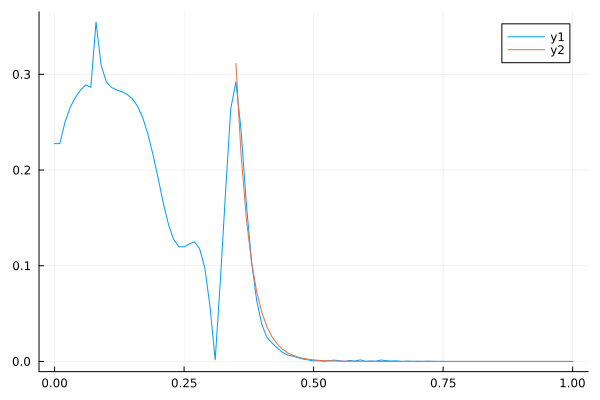

In [11]:
f_fit(s, p) = p[1] * (1 .- s).^p[2] ./ s.^(p[2]-1)

p0 = [1., dh]
fit = curve_fit(f_fit, S[argmin(abs.(S .- sc)):end], dH[argmin(abs.(S .- sc)):end], p0)

plot(S, dH)
plot!(S[argmin(abs.(S .- sc)):end], f_fit(S[argmin(abs.(S .- sc)):end], fit.param))
# plot!(xlims=[0.7, 1], ylims=[0., 0.0005])